In [32]:
import string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score

In [33]:
df_train = pd.read_pickle("train_pp.pkl")
df_test = pd.read_pickle("test_pp.pkl")

In [34]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc
145367,145367,229850,229851,Is there only one consciousness?,Is consciousness one for everyone?,1,"[is, there, only, one, consciousness, ?]","[is, consciousness, one, for, everyone, ?]",?,?,True
123169,123169,98309,199206,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,"[which, is, a, suitable, solar, panel, install...","[which, is, a, suitable, solar, panel, install...",?,?,True
57880,57880,101653,101654,Is there any idea for a new and useful mini pr...,Are there any new topics in computer science t...,0,"[is, there, any, idea, for, a, new, and, usefu...","[are, there, any, new, topic, in, computer, sc...",?,?,True
213043,213043,318261,318262,What does it mean if a girl cries after hurtin...,What does it mean if a girl cries without any ...,0,"[what, doe, it, mean, if, a, girl, cry, after,...","[what, doe, it, mean, if, a, girl, cry, withou...",?,?,True
204901,204901,307914,307915,What are some wholesale drop shippers that hav...,What portrait lenses are compatible with the C...,0,"[what, are, some, wholesale, drop, shipper, th...","[what, portrait, lens, are, compatible, with, ...",?,?,True


In [35]:
#use pre-trained:'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)'
#vocab: 400K
# api.info("glove-wiki-gigaword-100")
word_vectors = api.load("glove-wiki-gigaword-100")

In [36]:
stop_words = set(nltk.corpus.stopwords.words("english")) #179 words in total 
#adding back some words which is crucial for this application
#stop_words = stop_words.difference({"what","when","where","which","who","whom","how"})


In [37]:
len(stop_words)

179

In [38]:
def doc2vec(words):
    """
    simply adding word_vec for all words and compute means 
    all words should be in lower case; string.punctuations are skipped 
    words not in the word_vectors are skipped; 
    stop words are skipped 
    @param words: List[str]: a list of words
    return: 
    """
    sum_vec = np.zeros((word_vectors.vector_size,))
    cnt = 0 
    for w in words: 
        if not w in string.punctuation and not w in stop_words and w in word_vectors: 
            sum_vec = sum_vec + word_vectors[w]
            cnt += 1
    return sum_vec/cnt if cnt > 0 else sum_vec

In [39]:
def compute_distance(wv1,wv2): 
    """
    cosine distance
    @param wv1: word_vector
    @param wv2: word_vector
    return: float 
    """
    n_v1 = np.linalg.norm(wv1)
    n_v2 = np.linalg.norm(wv2)
    if n_v1 == 0.0 or n_v2 == 0.0: 
        return 0.0 if n_v1 == n_v2 else 2.0
    return cosine(wv1,wv2)    

In [40]:
f_qdist = lambda q1,q2: compute_distance(doc2vec(q1),doc2vec(q2)) 
df_train['qdist'] = df_train.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)
df_test['qdist'] = df_test.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)

In [41]:
np.percentile(df_train['qdist'],[0,5,10,25,50,75,90,95,100])

array([0.        , 0.        , 0.02038709, 0.0555436 , 0.11114994,
       0.20384298, 0.35349581, 0.47633876, 2.        ])

In [42]:
#sanity check: what are the pair of zero qdist like? 
sel = df_train['qdist'] == 0.
df_train[sel].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc,qdist
337973,337973,434644,349667,How can I introspect myself?,How do I introspect myself?,1,"[how, can, i, introspect, myself, ?]","[how, do, i, introspect, myself, ?]",?,?,True,0.0
386138,386138,518304,518305,Why is there both Fannie Mae & Freddie Mac?,What is Fannie Mae and Freddie Mac?,0,"[why, is, there, both, fannie, mae, &, freddie...","[what, is, fannie, mae, and, freddie, mac, ?]",?,?,True,0.0
64124,64124,111484,111485,I got denied by Google AdSense for 'insufficie...,I got denied by Google AdSense for 'insufficie...,0,"[i, got, denied, by, google, adsense, for, 'in...","[i, got, denied, by, google, adsense, for, 'in...",?,?,True,0.0
54372,54372,95997,95998,HOW DOESI FUCK A LADY?,How will I fuck a lady?,1,"[how, doesi, fuck, a, lady, ?]","[how, will, i, fuck, a, lady, ?]",?,?,True,0.0
233637,233637,343929,343930,How are airplanes made?,What are airplanes made out of?,0,"[how, are, airplane, made, ?]","[what, are, airplane, made, out, of, ?]",?,?,True,0.0


In [45]:
auc_train = roc_auc_score(1.0 - df_train['is_duplicate'], df_train['qdist'])
auc_test = roc_auc_score(1.0 - df_test['is_duplicate'], df_test['qdist'])

print("train_auc:%g, test_auc: %g" % (auc_train,auc_test))

train_auc:0.714389, test_auc: 0.713937


Text(0.5, 1.0, 'ROC for testing data')

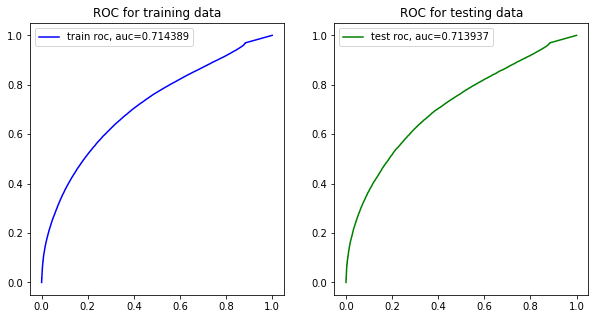

In [46]:
fpr_train, tpr_train, thresholds_train = roc_curve(1.0 - df_train['is_duplicate'], df_train['qdist'])
fpr_test, tpr_test, thresholds_test = roc_curve(1.0 - df_test['is_duplicate'], df_test['qdist'])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,tpr_train, color="blue", label="train roc, auc=%g" % (auc_train,))
plt.legend()
plt.title("ROC for training data")
plt.subplot(1,2,2)
plt.plot(fpr_test,tpr_test, color="green", label="test roc, auc=%g" % (auc_test,))
plt.legend()
plt.title("ROC for testing data")

In [47]:
#build a logistic regression model so that we can calculate probability and accurary 
from sklearn.linear_model import LogisticRegression
X_train = df_train['qdist'].values[:,np.newaxis]
X_test = df_test['qdist'].values[:,np.newaxis]
y_train = df_train['is_duplicate'].values
y_test = df_test['is_duplicate'].values
model = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train,y_train)

In [48]:
model.coef_,model.intercept_

(array([[-7.41274407]]), array([0.42741563]))

In [49]:
y_pred_train = model.predict_proba(X_train)
y_pred_test = model.predict_proba(X_test)

In [50]:
y_pred_train.shape, y_pred_train[0],model.classes_

((323432, 2), array([0.48911201, 0.51088799]), array([0, 1]))

In [51]:
auc_test = roc_auc_score(y_test,y_pred_test[:,1])
accuracy_test = accuracy_score(y_test,y_pred_test[:,1]>0.5)
auc_train = roc_auc_score(y_train,y_pred_train[:,1])
accuracy_train = accuracy_score(y_train,y_pred_train[:,1]>0.5)

print("auc_train=%g, auc_test=%g, accuracy_train=%g, accuracy_test=%g" % (auc_train, auc_test, accuracy_train, accuracy_test))

auc_train=0.714389, auc_test=0.713937, accuracy_train=0.666799, accuracy_test=0.665648


In [52]:
np.savez("word2vec_v1_roc.npz", 
         fpr_train=fpr_train, tpr_train=tpr_train, thresholds_train= thresholds_train, 
         fpr_test = fpr_test, tpr_test=tpr_test, thresholds_test = thresholds_test)